In [75]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import csv
import numpy.linalg as LA

In [45]:
import sys
sys.path.append(r"C:\Users\vl385\Documents\casadi-windows-py37-v3.5.1")
from casadi import *

In [46]:
x_list = []
y_list = []

input_file = "data-for-mpc.csv"
with open(input_file) as csv_file:
    reader = csv.reader(csv_file)
    for line in reader:
        x_list.append(float(line[0]))
        y_list.append(float(line[1]))
        

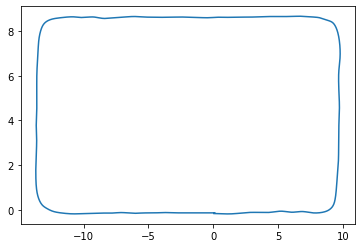

In [47]:
from numpy import genfromtxt
data = genfromtxt('data-for-mpc.csv', delimiter=',')
x_list = data[:, 0] 
y_list = data[:, 1]
Ar_list = data[:, 2:4]
br_list = data[:, 4]

plt.plot(x_list, y_list)

In [101]:
class auto_car:
    T = 0.2; H = 10; L = 10;
    lf = 0.16; lr = 0.17
    
    v_min = 0; v_max = 2
    delta_min = -0.4; delta_max = 0.4
    
    Q = 0
    R = 0

    opti = None # Optimizer
    
    def __init__(self, x0):
        self.st = x0
        self.est_st = x0
        self.input = np.array([0, 0])
        self.ramp_v_min = -5*self.T; self.ramp_v_max = 5*self.T; 
        self.ramp_delta_min = -np.pi*self.T; self.ramp_delta_max = np.pi*self.T
        self.Y_hist = self.st.reshape(-1,1)
        self.U_hist = np.empty((2,0))
        
    def set_weight(self, Q, R, Q_mhe, R_mhe):
        self.Q = Q
        self.R = R
        self.Q_mhe = Q_mhe
        self.R_mhe = R_mhe
        
    def load_data(self, ref, Ar, br):
        self.ref = ref
        self.Ar = Ar
        self.br = br
    
    def formulateMPC(self):
        x = SX.sym('x'); y = SX.sym('y'); phi = SX.sym('phi') 
        v = SX.sym('v'); delta = SX.sym('delta') 
        state = np.array([x, y, phi])
        control = np.array([v, delta])
        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        rhs = np.array([v*np.cos(phi+beta), v*np.sin(phi+beta), v*np.sin(beta)/self.lr])*self.T + state
        self.f_dyn = Function('f_dyn', [state,control], [rhs])
        
        self.mpc_opti = casadi.Opti()
        self.U = self.mpc_opti.variable(2, self.H)
        self.X = self.mpc_opti.variable(3, self.H+1)
        self.P_1 = self.mpc_opti.parameter(3)
        self.P_2 = self.mpc_opti.parameter(2)
        self.P_3 = self.mpc_opti.parameter(2, self.H)
        self.P_Ar = self.mpc_opti.parameter(self.H, 2)
        self.P_br = self.mpc_opti.parameter(self.H)
        
        J = 0
        for k in range(self.H):
            p_H = self.X[0:2, k+1];
            u_H = self.U[:,k]
            J += mtimes([(p_H-self.P_3[:,k]).T, self.Q, (p_H-self.P_3[:,k])]) \
                + mtimes([u_H.T, self.R, u_H])
            self.mpc_opti.subject_to(mtimes(self.P_Ar[k, :], p_H) - self.P_br[k] <= 0.1)
            self.mpc_opti.subject_to(mtimes(self.P_Ar[k, :], p_H) - self.P_br[k] >= -0.1) 
            
        self.mpc_opti.minimize(J) 
        
        for k in range(self.H):
            self.mpc_opti.subject_to(self.X[:,k+1] == self.f_dyn(self.X[:,k], self.U[:,k]))
            
        self.mpc_opti.subject_to(self.v_min <= self.U[0,:])
        self.mpc_opti.subject_to(self.U[0,:] <= self.v_max)
        self.mpc_opti.subject_to(self.delta_min <= self.U[1,:])
        self.mpc_opti.subject_to(self.U[1,:] <= self.delta_max)
        
        self.mpc_opti.subject_to(self.ramp_v_min <= self.U[0,0] - self.P_2[0])
        self.mpc_opti.subject_to(self.U[0,0] - self.P_2[0] <= self.ramp_v_max)
        self.mpc_opti.subject_to(self.ramp_delta_min <= self.U[1,0] - self.P_2[1])
        self.mpc_opti.subject_to(self.U[1,0] - self.P_2[1] <= self.ramp_delta_max)
        
        self.mpc_opti.subject_to(self.ramp_v_min <= self.U[0,1:] - self.U[0,0:-1])
        self.mpc_opti.subject_to(self.U[0,1:] - self.U[0,0:-1] <= self.ramp_v_max)
        self.mpc_opti.subject_to(self.ramp_delta_min <= self.U[1,1:] - self.U[1,0:-1])
        self.mpc_opti.subject_to(self.U[1,1:] - self.U[1,0:-1] <= self.ramp_delta_max)

        self.mpc_opti.subject_to(self.X[:,0] == self.P_1[0:3])
        
        p_opts = {'verbose_init': False}
        s_opts = {'tol': 0.01, 'print_level': 0, 'max_iter': 100}
        self.mpc_opti.solver('ipopt', p_opts, s_opts)

        # Warm up
        self.mpc_opti.set_value(self.P_1, self.est_st)
        self.mpc_opti.set_value(self.P_2, self.input)
        self.mpc_opti.set_value(self.P_3, ref[:,0:car.H])
        self.mpc_opti.set_value(self.P_Ar, self.Ar[0:car.H, :])
        self.mpc_opti.set_value(self.P_br, self.br[0:car.H])
        
        sol = self.mpc_opti.solve()
        self.mpc_opti.set_initial(self.U, sol.value(self.U))
        self.mpc_opti.set_initial(self.X, sol.value(self.X))

    def solveMPC(self, i):
        if np.size(car.U_hist, 1) < self.L:
            self.U_hist = np.hstack([self.U_hist, self.input.reshape(-1,1)]) 
        else:
            self.U_hist = np.hstack([self.U_hist[:,1:], self.input.reshape(-1,1)])
            
        if np.size(car.Y_hist, 1) < self.L+1:
            self.Y_hist = np.hstack([self.Y_hist, self.st.reshape(-1,1) + np.random.uniform(-0.2, 0.2, (3, 1))])
        else:
            self.Y_hist = np.hstack([self.Y_hist[:,1:], self.st.reshape(-1,1) + np.random.uniform(-0.2, 0.2, (3, 1))])
        self.solveMHE(i)
        
        self.mpc_opti.set_value(self.P_1, self.est_st)
        self.mpc_opti.set_value(self.P_2, self.input)
        self.mpc_opti.set_value(self.P_3, ref[:,i:i+car.H])
        self.mpc_opti.set_value(self.P_Ar, self.Ar[i:i+car.H, :])
        self.mpc_opti.set_value(self.P_br, self.br[i:i+car.H])
        try:
            sol = self.mpc_opti.solve()
        except RuntimeError:
            print("An exception occurred")
            control = self.mpc_opti.debug.value(self.U)
        else:
            control = sol.value(self.U)
            self.mpc_opti.set_initial(self.X, np.hstack((sol.value(self.X)[:,1:], sol.value(self.X)[:,-1:])))
            self.mpc_opti.set_initial(self.U, np.hstack((sol.value(self.U)[:,1:], sol.value(self.U)[:,-1:])))    

        return control[:,0]
    
    def formulateMHE(self):
        self.mhe_opti = casadi.Opti()
        self.U_mhe = self.mhe_opti.variable(2, self.L)
        self.X_mhe = self.mhe_opti.variable(3, self.L+1)
        self.P_y = self.mhe_opti.parameter(3, self.L+1)
        self.P_u = self.mhe_opti.parameter(2, self.L)
        
        J = 0
        for k in range(self.L+1):
            J += mtimes([(self.P_y[:,k] - self.X_mhe[:,k]).T, self.Q_mhe, (self.P_y[:,k] - self.X_mhe[:,k])])

        for k in range(self.L):
            J += mtimes([(self.P_u[:,k] - self.U_mhe[:,k]).T, self.R_mhe, (self.P_u[:,k] - self.U_mhe[:,k])])

        self.mhe_opti.minimize(J)
        
        for k in range(self.L):
            self.mhe_opti.subject_to(self.X_mhe[:,k+1] == self.f_dyn(self.X_mhe[:,k], self.U_mhe[:,k]))
            
        self.mhe_opti.subject_to(self.v_min <= self.U_mhe[0,:])
        self.mhe_opti.subject_to(self.U_mhe[0,:] <= self.v_max)
        self.mhe_opti.subject_to(self.delta_min <= self.U_mhe[1,:])
        self.mhe_opti.subject_to(self.U_mhe[1,:] <= self.delta_max)
        
        self.mhe_opti.subject_to(self.ramp_v_min <= self.U_mhe[0,1:] - self.U_mhe[0,0:-1])
        self.mhe_opti.subject_to(self.U_mhe[0,1:] - self.U_mhe[0,0:-1] <= self.ramp_v_max)
        self.mhe_opti.subject_to(self.ramp_delta_min <= self.U_mhe[1,1:] - self.U_mhe[1,0:-1])
        self.mhe_opti.subject_to(self.U_mhe[1,1:] - self.U_mhe[1,0:-1] <= self.ramp_delta_max)
        
        p_opts = {'verbose_init': False}
        s_opts = {'tol': 0.01, 'print_level': 0, 'max_iter': 100}
        self.mhe_opti.solver('ipopt', p_opts, s_opts)
        
    def solveMHE(self, i):
        if i >= self.L:
            self.mhe_opti.set_value(self.P_y, self.Y_hist)
            self.mhe_opti.set_value(self.P_u, self.U_hist)

            try:
                sol = self.mhe_opti.solve()
            except RuntimeError:
                print("An exception occurred")
                output = self.mhe_opti.debug.value(self.X_mhe)
            else:
                output = sol.value(self.X_mhe)
                self.mhe_opti.set_initial(self.X_mhe, np.hstack((sol.value(self.X_mhe)[:,1:], sol.value(self.X_mhe)[:,-1:])))
                self.mhe_opti.set_initial(self.U_mhe, np.hstack((sol.value(self.U_mhe)[:,1:], sol.value(self.U_mhe)[:,-1:])))  
            self.est_st = output[:,-1]
        else: self.est_st = self.st
        print(self.est_st, self.st)
        
    def car_model(self, z, t, u):
        phi = z[2]
        v = u[0]; delta = u[1]

        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        dz = np.zeros(3)
        dz[0] = v*np.cos(phi+beta)
        dz[1] = v*np.sin(phi+beta)
        dz[2] = v/self.lr*np.sin(beta)
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u


In [102]:
x_sel = x_list[::5]
y_sel = y_list[::5]
Ar_sel = Ar_list[::5]
br_sel = br_list[::5]

N = len(x_sel)
N

339

In [103]:
car = auto_car(np.zeros((3)))
car.set_weight(np.diag([10,10]), np.diag([0.1, 10]), np.diag([1,1,1]), np.diag([1, 1]))
ref = np.hstack([np.vstack([x_sel, y_sel]), [[x_sel[-1]], [y_sel[-1]]]*np.ones(car.H)])
Ar = np.vstack([Ar_sel, Ar_sel[-1, :]*np.ones((car.H,2))])
br = np.hstack([br_sel, br_sel[-1]*np.ones(car.H)])
car.load_data(ref, Ar, br)
car.formulateMPC()
car.formulateMHE()


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        20
       nlp_g  |   1.00ms ( 50.00us)   1.00ms ( 50.00us)        20
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        13
  nlp_hess_l  |   1.00ms ( 90.91us)   1.00ms ( 90.91us)        11
   nlp_jac_g  |        0 (       0)        0 (       0)        13
       total  |  10.00ms ( 10.00ms)   10.00ms (  10.00ms)         1


In [104]:
X_hist = np.empty((3,N+1))
X_hist[:,0] = car.st
for i in range(N):
    u = car.solveMPC(i)
    car.run(u)
    X_hist[:,i+1] = car.st

[0. 0. 0.] [0. 0. 0.]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |        0 (       0)        0 (       0)         6
   nlp_jac_g  |   1.00ms (125.00us)   1.00ms (125.00us)         8
       total  |  12.00ms ( 12.00ms)  12.00ms ( 12.00ms)         1
[ 2.28452971e-05 -1.84041915e-10 -1.08252676e-09] [ 2.28452971e-05 -1.84041915e-10 -1.08252676e-09]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         7
       nlp_g  |   1.00ms (142.86us) 999.00us (142.71us)         7
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |     

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |   1.00ms (142.86us) 999.00us (142.71us)         7
       total  |   5.00ms (  5.00ms)   5.00ms (  5.00ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |   1.00ms (142.86us)   1.00ms (142.86us)         7
       tot

   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |   5.00ms (  5.00ms)   4.97ms (  4.97ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |   1.00ms (200.00us)   1.01ms (201.80us)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |   4.00ms (  4.00ms)   4.00ms (  4.00ms)         1
[ 8.58159492 -0.02728452  0.16806627] [8.53957517 0.0326365  0.26347573]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)        30
       nlp_g  |        0 (       0)        0 (       0)        30
    nlp_grad  |        0 (       0)        0 (       0)         1
  n

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |   5.00ms (  5.00ms)   5.01ms (  5.01ms)         1
[9.49264078 0.94321186 1.22054619] [9.52012693 0.9877863  1.19544581]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         7
       nlp_g  |        0 (       0)        0 (       0)         7
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |        0 (       0)        0 (       0)         6
   nlp

  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |   4.00ms (  4.00ms)   4.01ms (  4.01ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |   5.00ms (  5.00ms)   5.00ms (  5.00ms)         1
[9.73971689 4.32734188 1.50155049] [9.72707486 4.33524743 1.5749183 ]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
      

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms (200.00us) 999.00us (199.80us)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |   5.00ms (  5.00ms)   4.97ms (  4.97ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)         8
   nlp_jac_g  |   1.00ms (100.00us)   1.00ms (100.10us)        10
       total  |  20.00ms ( 20.00ms)  19.95ms ( 19.95ms)         1
[8.89860576 8.38056418 2.59873354] [8.90952889 8.37511251 2.56706766]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         7
       nlp_g  |        0 (       0)        0 (       0)         7
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |        0 (       0)        0 (       0)         6
   nlp

  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |        0 (       0)        0 (       0)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |  16.00ms ( 16.00ms)  15.62ms ( 15.62ms)         1
[5.57150001 8.62544458 3.14278032] [5.53636854 8.68717474 3.10771197]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nl

    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |        0 (       0)        0 (       0)         1
[2.09115726 8.60894872 3.30893952] [2.05406656 8.54542013 3.27930161]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |        0 (       0)        0 (       0)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
      

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |  16.00ms ( 16.00ms)  15.61ms ( 15.61ms)         1
[-2.13342961  8.65303639  3.15744951] [-2.15873854  8.63412439  3.10687484]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |  16.00ms ( 16.00ms)  15.66ms ( 15.66ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

[-9.50201553  8.63124373  3.10078749] [-9.47495437  8.66037453  3.07126567]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |        0 (       0)        0 (       0)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)         8
   nlp_jac_g  |        0 (       0)        0 (       0)        10
       total  |  16.00ms ( 16.00ms)  15.62ms ( 15.62ms)         1
[-12.971959     8.27344555   3.71478334] [-12.96308817   8.18908681   3.76300697]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |        0 (       0)        0 (       0)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |        0 (       0)        0 (       0)     

    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |        0 (       0)        0 (       0)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         7
       nlp_g  |        0 (       0)        0 (       0)         7
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |        0 (       0)        0 (       0)         6
   nlp_jac_g  |        0 (       0)        0 (       0)         8
       total  |        0 (       0)        0 (       0)         1
[-13.57090271   5.92345257   4.5860773 ] [-13.61230465   5.87242339   4.60340061]
      solver  :   t_proc      (avg)   t_wall      (avg)    n

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |  16.00ms ( 16.00ms)  15.66ms ( 15.66ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (111.11us)   1.04ms (115.22us)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |        0 (       0)        0 (       0)         9
       total  |   5.00ms (  5.00ms)   5.03ms (  5.03ms)         1
[-12.91352814   0.17433232   5.65716287] [-12.88458482   0.18600974   5.65638956]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         9
       nlp_g  |   1.00ms (111.11us)   1.00ms (111.22us)         9
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        10
  nlp_hess_l  |        0 (       0)        0 (       0)     

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |        0 (       0)        0 (       0)         1
[-9.76191176 -0.13793358  6.29354097] [-9.77074728 -0.14424827  6.28251732]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5


    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |        0 (       0)        0 (       0)         1
[-5.59807569 -0.13413142  6.3240909 ] [-5.56164905 -0.230696    6.22698679]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |        0 (       0)        0 (       0)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |  16.00ms ( 16.00ms)  15.62ms ( 15.62ms)         1
[-1.39917575 -0.13506194  6.18228177] [-1.39261358 -0.12985799  6.3003094 ]
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4


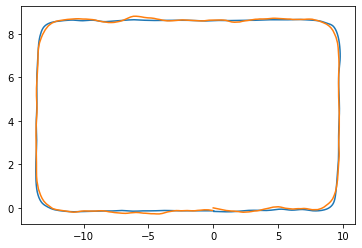

In [105]:
plt.plot(ref[0,:], ref[1,:])        
plt.plot(X_hist[0,:], X_hist[1,:])

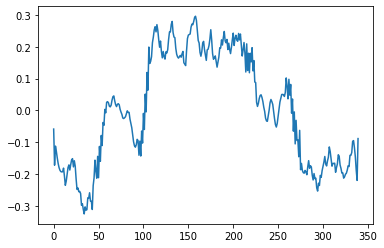

In [106]:
plt.plot(X_hist[0,:] - ref[0,0:N+1])

In [11]:
np.random.uniform(-0.1, 0.1, (3, 1))

array([[-0.06080611],
       [-0.06390925],
       [ 0.05564757]])

In [97]:
class auto_car:
    T = 0.2; H = 10
    lf = 0.16; lr = 0.17
    
    v_min = 0; v_max = 2
    delta_min = -0.4; delta_max = 0.4
    
    Q = 0
    R = 0
    
    def __init__(self, x0):
        self.st = x0
        self.input = np.array([0, 0])
        self.ramp_v_min = -5*self.T; self.ramp_v_max = 5*self.T; 
        self.ramp_delta_min = -np.pi*self.T; self.ramp_delta_max = np.pi*self.T
        
    def set_weight(self, Q, R):
        self.Q = Q
        self.R = R
        
    def load_data(self, ref, Ar, br):
        self.ref = ref
        self.Ar = Ar
        self.br = br
        
    def init_EKF(self, Q, R):
        self.est_st = self.st
        self.Qk = Q
        self.Rk = R
        self.Pk = np.zeros((3,3))
        
    def perform_EKF(self, u, z):
        # Predict
        self.est_st = self.f_dyn(self.est_st, u)
        F = self.Fk(self.est_st, u).full()
        self.Pk = np.dot(F, np.dot(self.Pk, F.transpose())) + self.Qk
        # Update
        y = z - self.est_st
        S = self.Pk + self.Rk
        K = self.Pk*LA.inv(S)
        self.x = self.est_st + K*y
        self.Pk = (np.eye(3) - K)*self.Pk
    
    def formulateMPC(self):
        x = SX.sym('x'); y = SX.sym('y'); phi = SX.sym('phi') 
        v = SX.sym('v'); delta = SX.sym('delta') 
        state = np.array([x, y, phi])
        control = np.array([v, delta])
        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        rhs = np.array([v*np.cos(phi+beta), v*np.sin(phi+beta), v*np.sin(beta)/self.lr])*self.T + state
        self.f_dyn = Function('f_dyn', [state,control], [rhs])
        self.Fk = Function('Fk', [state, control], [jacobian(rhs, state)])

        self.mpc_opti = casadi.Opti()
        self.U = self.mpc_opti.variable(2, self.H)
        self.X = self.mpc_opti.variable(3, self.H+1)
        self.P_1 = self.mpc_opti.parameter(3)
        self.P_2 = self.mpc_opti.parameter(2)
        self.P_3 = self.mpc_opti.parameter(2, self.H)
        self.P_Ar = self.mpc_opti.parameter(self.H, 2)
        self.P_br = self.mpc_opti.parameter(self.H)
        
        J = 0
        for k in range(self.H):
            p_H = self.X[0:2, k+1];
            u_H = self.U[:,k]
            J += mtimes([(p_H-self.P_3[:,k]).T, self.Q, (p_H-self.P_3[:,k])]) \
                + mtimes([u_H.T, self.R, u_H])
            
        self.mpc_opti.minimize(J) 
        
        for k in range(self.H):
            self.mpc_opti.subject_to(self.X[:,k+1] == self.f_dyn(self.X[:,k], self.U[:,k]))
            
        self.mpc_opti.subject_to(self.v_min <= self.U[0,:])
        self.mpc_opti.subject_to(self.U[0,:] <= self.v_max)
        self.mpc_opti.subject_to(self.delta_min <= self.U[1,:])
        self.mpc_opti.subject_to(self.U[1,:] <= self.delta_max)
        
        self.mpc_opti.subject_to(self.ramp_v_min <= self.U[0,0] - self.P_2[0])
        self.mpc_opti.subject_to(self.U[0,0] - self.P_2[0] <= self.ramp_v_max)
        self.mpc_opti.subject_to(self.ramp_delta_min <= self.U[1,0] - self.P_2[1])
        self.mpc_opti.subject_to(self.U[1,0] - self.P_2[1] <= self.ramp_delta_max)
        
        self.mpc_opti.subject_to(self.ramp_v_min <= self.U[0,1:] - self.U[0,0:-1])
        self.mpc_opti.subject_to(self.U[0,1:] - self.U[0,0:-1] <= self.ramp_v_max)
        self.mpc_opti.subject_to(self.ramp_delta_min <= self.U[1,1:] - self.U[1,0:-1])
        self.mpc_opti.subject_to(self.U[1,1:] - self.U[1,0:-1] <= self.ramp_delta_max)

        self.mpc_opti.subject_to(self.X[:,0] == self.P_1[0:3])
        
        p_opts = {'verbose_init': False}
        s_opts = {'tol': 0.01, 'print_level': 0, 'max_iter': 100}
        self.mpc_opti.solver('ipopt', p_opts, s_opts)

        # Warm up
        self.mpc_opti.set_value(self.P_1, self.st)
        self.mpc_opti.set_value(self.P_2, self.input)
        self.mpc_opti.set_value(self.P_3, ref[:,0:car.H])
        self.mpc_opti.set_value(self.P_Ar, self.Ar[0:car.H, :])
        self.mpc_opti.set_value(self.P_br, self.br[0:car.H])
        
        sol = self.mpc_opti.solve()
        self.mpc_opti.set_initial(self.U, sol.value(self.U))
        self.mpc_opti.set_initial(self.X, sol.value(self.X))

    def solveMPC(self, i):
        self.perform_EKF(self.input, self.st+ 1*rd.uniform(-1, 1, (3,1)))
        self.mpc_opti.set_value(self.P_1, self.est_st)
        self.mpc_opti.set_value(self.P_2, self.input)
        self.mpc_opti.set_value(self.P_3, ref[:,i:i+car.H])
        self.mpc_opti.set_value(self.P_Ar, self.Ar[i:i+car.H, :])
        self.mpc_opti.set_value(self.P_br, self.br[i:i+car.H])
        try:
            sol = self.mpc_opti.solve()
        except RuntimeError:
            print("An exception occurred")
            control = self.mpc_opti.debug.value(self.U)
        else:
            control = sol.value(self.U)
            self.mpc_opti.set_initial(self.X, np.hstack((sol.value(self.X)[:,1:], sol.value(self.X)[:,-1:])))
            self.mpc_opti.set_initial(self.U, np.hstack((sol.value(self.U)[:,1:], sol.value(self.U)[:,-1:])))    

        return control[:,0]
        
    def car_model(self, z, t, u):
        phi = z[2]
        v = u[0]; delta = u[1]

        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        dz = np.zeros(3)
        dz[0] = v*np.cos(phi+beta)
        dz[1] = v*np.sin(phi+beta)
        dz[2] = v/self.lr*np.sin(beta)
        return dz
        
    def run(self, u):
        tspan = np.linspace(0, self.T, 3)
        y = odeint(self.car_model, self.st, tspan, args=(u,)) 
        self.st = y[-1,] 
        self.input = u


In [98]:
car = auto_car(np.zeros((3)))
car.set_weight(np.diag([10,10]), np.diag([0.1, 10]))
ref = np.hstack([np.vstack([x_sel, y_sel]), [[x_sel[-1]], [y_sel[-1]]]*np.ones(car.H)])
Ar = np.vstack([Ar_sel, Ar_sel[-1, :]*np.ones((car.H,2))])
br = np.hstack([br_sel, br_sel[-1]*np.ones(car.H)])
car.load_data(ref, Ar, br)
car.formulateMPC()
car.init_EKF(np.eye(3), np.eye(3))


      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 50.00us)   1.00ms ( 50.00us)        20
       nlp_g  |        0 (       0)        0 (       0)        20
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)        13
  nlp_hess_l  |        0 (       0)        0 (       0)        11
   nlp_jac_g  |   1.00ms ( 76.92us) 998.00us ( 76.77us)        13
       total  |  10.00ms ( 10.00ms)   10.00ms (  10.00ms)         1


In [99]:
X_hist = np.empty((3,N+1))
X_hist[:,0] = car.st
for i in range(N):
    u = car.solveMPC(i)
    car.run(u)
    X_hist[:,i+1] = car.st

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |        0 (       0)        0 (       0)         6
   nlp_jac_g  |        0 (       0)        0 (       0)         8
       total  |   7.00ms (  7.00ms)   7.00ms (  7.00ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         7
       nlp_g  |        0 (       0)        0 (       0)         7
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |        0 (       0)        0 (       0)         6
   nlp_jac_g  |        0 (       0)        0 (       0)         8
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |   4.00ms (  4.00ms)   4.03ms (  4.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (166.67us)   1.03ms (171.17us)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |   4.00ms (  4.00ms)   4.03ms (  4.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |   1.00ms (166.67us)   1.00ms (167.00us)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |   3.00ms (  3.00ms)   3.04ms (  3.04ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       tot

  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |   4.00ms (  4.00ms)   4.02ms (  4.02ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |   1.00ms (166.67us)   1.02ms (170.17us)         6
       total  |   4.00ms (  4.00ms)   4.04ms (  4.04ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       total  |   4.00ms (  4.00ms)   4.03ms (  4.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         6
       nlp_g  |        0 (       0)        0 (       0)         6
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         7
  nlp_hess_l  |        0 (       0)        0 (       0)         5
   nlp_jac_g  |        0 (       0)        0 (       0)         7
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |   1.00ms (166.67us)   1.00ms (166.67us)         6
       total  |   7.00ms (  7.00ms)   7.03ms (  7.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |   1.00ms (200.00us)   1.03ms (206.20us)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.00ms (400.00us)   2.04ms (408.00us)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |  18.00ms ( 18.00ms)  17.66ms ( 17.66ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |   1.00ms (111.11us)   1.03ms (114.56us)         9
  nlp_hess_l  |        0 (       0)        0 (       0)         7
   nlp_jac_g  |   1.00ms (111.11us) 999.00us (111.00us)         9
       total  |   6.00ms (  6.00ms)   6.38ms (  6.38ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         8
  nlp_hess_l  |   1.00ms (166.67us)   1.00ms (167.50us)         6
   nlp_jac_g  |        0 (       0)        0 (       0)         8
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       total  |  16.00ms ( 16.00ms)  15.66ms ( 15.66ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |   1.00ms (166.67us)   1.04ms (172.67us)         6
       total  |   6.00ms (  6.00ms)   6.04ms (  6.04ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         5
       nlp_g  |        0 (       0)        0 (       0)         5
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         6
  nlp_hess_l  |        0 (       0)        0 (       0)         4
   nlp_jac_g  |        0 (       0)        0 (       0)         6
       tot

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)        0 (       0)         8
       nlp_g  |        0 (       0)        0 (       0)         8
    nlp_grad  |        0 (       0)        0 (       0)         1
  nlp_grad_f  |        0 (       0)        0 (       0)         9
  nlp_hess_l  |   1.00ms (142.86us) 997.00us (142.43us)         7
   nlp_jac_g  |   1.00ms (111.11us) 967.00us (107.44us)         9
       total  |  10.00ms ( 10.00ms)   10.00ms (  10.00ms)         1


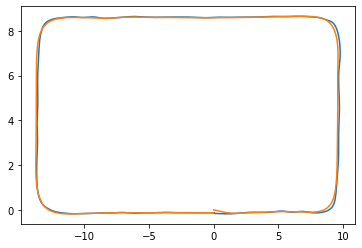

In [100]:
plt.plot(ref[0,:], ref[1,:])        
plt.plot(X_hist[0,:], X_hist[1,:])

In [68]:
car.Qk

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [2]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

In [7]:
my_filter = KalmanFilter(dim_x=2, dim_z=1)


In [12]:
my_filter.x = np.array([[2.],
                [0.]])       # initial state (location and velocity)

my_filter.F = np.array([[1.,1.],
                [0.,1.]])    # state transition matrix

my_filter.H = np.array([[1.,0.]])    # Measurement function
my_filter.P *= 1000.                 # covariance matrix
my_filter.R = 5                      # state uncertainty
my_filter.Q = Q_discrete_white_noise(2, 4, .1) # process uncertainty

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [39]:
class EKF:
    T = 0.2
    lf = 0.16; lr = 0.17
    def __init__(self, dim_x, dim_u, dim_z, x0, Q, R):
        self.x = x0
        self.dim_x = dim_x
        self.dim_u = dim_u
        self.dim_z = dim_z
        self.Q = Q
        self.R = R
        x = SX.sym('x'); y = SX.sym('y'); phi = SX.sym('phi') 
        v = SX.sym('v'); delta = SX.sym('delta') 
        state = np.array([x, y, phi])
        control = np.array([v, delta])
        beta = np.arctan(self.lr/(self.lf+self.lr)*np.tan(delta))
        rhs = np.array([v*np.cos(phi+beta), v*np.sin(phi+beta), v*np.sin(beta)/self.lr])*self.T + state
        self.f_dyn = Function('f_dyn', [state,control], [rhs])
        self.Fk = Function('Fk', [state, control], [jacobian(rhs, state)])

    def predict(self, u0):
        self.x = self.f_dyn(self.x, u0)
        F = self.Fk(self.x, u0)
        self.Pk = np.dot(F, np.dot(self.P, F.transpose())) + self.Q
        
    def update(self, z):
        self.y = z - self.x
        S = self.P + self.R
        K = self.P*LA.inv(S)
        self.x = self.x + K*self.y
        self.P = (eye(self.dim_x) - K)*self.P

In [40]:
Filter = EKF(3, 2, 3, np.zeros((3,1)), np.eye(3), np.eye(3))

In [86]:
import numpy.random as rd

array([[ 0.42332412],
       [-0.79330481],
       [ 0.18565437]])